In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 4

# Tarea 1 Máquinas de Aprendizaje

Patricio Horth M. y Víctor Zúñiga M.

13 de Octubre de 2017

## 1. Regresión Lineal Ordinaria (LSS)

Se comenzará el informe con la contrucción de un modelo para precedir el precio de una casa. Como datos de entrada se usará un *dataset* con las ventas en el condado de King County, EEUU entre Mayo de 2014 y Mayo de 2015. Para esto, se utilizará una regresión lineal ordinaria basada en LSS (Linear Least Squares)

## a) Ingreso de los datos

Los datos fueron obtenidos de Kaggle, y se encuentran en un archivo CSV. Las características o *features* id (número identificador), date (fecha) y zipcode (código postal) serán descartadas ya que de ante mano podemos suponer que no tienen relación con el precio de la casa.

In [2]:
df = pd.read_csv("kc_house_data.csv",sep = ",",header = 0)
df = df.drop(['id','date','zipcode'], axis=1)

## b) Análisis Descriptivo de los Datos

Primero es útil revisar el tamaño del dataset, junto con todo el resto de las características.

In [3]:
df.shape

(21613, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.0 MB


Tenemos que cada variable representa:

**price**: Es el precio de la casa, para nuestro análisis sera la variable a predecir.<br>
**bedrooms**: Cantidad de dormitorios que posee la casa. <br>
**bathrooms**: Cantidad de baños que posee la casa.<br>
**sqft_living**: Pies cuadrados de la casa.<br>
**sqft_lot**: Pies cuadrados del terreno donde se encuentra construida la casa.<br>
**floors**: Cantidad de pisos que posee la casa. <br>
**waterfront**: Si la casa tiene vista al mar.<br>
**condition**: Condicion en la que se encuentra la casa.<br>
**grade**: Grado general dado a la unidad de vivienda, basado en el sistema de clasificación del Condado de King.<br>
**sqft_above**: Metros cuadrados de la casa sin el sotano.       <br>
**sqft_basement**: Metros cuadrados del sotano.<br>
**yr_built**: Año de construccion de la casa.  <br>
**yr_renovated**: Año en que la casa fue renovada.   <br>
**lat**: Latitud.<br>
**long**: Longitud.<br>
**sqft_living15**: Tamaño del living room al año 2015.<br>
**sqft_lot15**: Tamaño del terreno al año 2015.   <br>

In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


## c) Transformación de las Variables

Los modelos de regresión lineal múltiple asumen ciertas cosas sobre el *dataset*:

* Las variables dependientes e independientes tienen una relación lineal
* Las variables siguen una distribución normal

Una función entregada por SciKit que nos puede ayudar para el segundo punto es StandardScaler, el cual hace lo que se llama Estandarización o Z-score normalization. Esto es, transformar las variables en sus z-scores a partir de:

$$x - \mu \over \sigma$$

Siendo $\mu$ el promedio de la población y $\sigma$ la desviación estándar de ésta. Esto va a permitir que los datos tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

Para el caso de nuestra variable dependiente **precio**, se va a hacer además una transformación logarítmica. Ésta es una práctica común al trabajar con variables referidas a dinero, y tiene varias ventajas:

* Los precios en general tienen *skewness*, o sea, su histograma está desbalanceado, con la mayor parte de los datos acumulados en cierto rango de valores. Una transformacion logarítmica puede ayudar a balancear el histograma (mejorar la simetría), y hacer que su comportamiento sea similar a una distribución normal.
* Los cambios en el valor logarítmico de una variable pueden ser directamente interpretados como cambios porcentuales.
* El logaritmo puede convertir relaciones multiplicativas en relaciones aditivas (como en el caso anterior, donde los cambios son convertidos en adiciones), y por tanto, hace que patrones de crecimiento exponencial se conviertan en patrones lineales, los cuales funcionan mucho mejor con nuestro modelo. [1] [2] [3]

In [6]:
#Se guarda en la variable X todo el dataset
X = df
#Transformacion Logaritmica
y = np.log(df['price'])

# Se crea un vector "mascara" del largo del dataframe X, 
# y se elige un limite del 70% del dataset para ser usado como conjunto de entrenamiento
# El otro 30% sera un conjunto de prueba
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

# Se quita la columna de precio de X despues de la normalización, ya que esto estara en el vector Y
Xtrain = Xtrain.drop(['price'], axis=1)
Xtest = Xtest.drop(['price'], axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Xtrain)
df_scaled_train = pd.DataFrame(scaler.transform(Xtrain), columns=Xtrain.columns)
df_scaled_train.insert(df_scaled_train.shape[1], 'intercept', np.ones(df_scaled_train.shape[0]))

df_scaled_test = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)
df_scaled_test.insert(df_scaled_test.shape[1], 'intercept', np.ones(df_scaled_test.shape[0]))

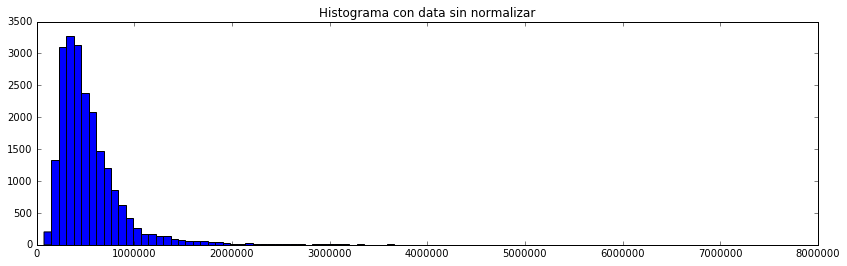

In [7]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma con data sin normalizar")
plt.hist(df['price'],bins=100)
plt.show()

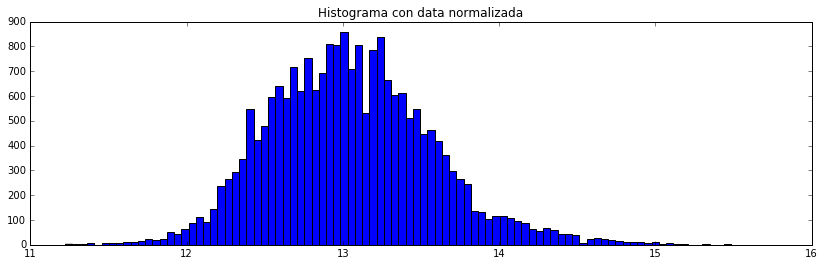

In [8]:
plt.title("Histograma con data normalizada")
plt.hist(np.log(df['price']), bins=100)
plt.show()

Como vemos, logramos hacer que la media de las variables independientes sea muy cercana a cero, y que logre seguir distribuciones parecidas a una Gaussiana. Para el caso de la variable de precio, obtuvimos una escala distinta, pero también de tipo gaussiana.

## d) Contrucción del Modelo

A continuación se hará la regresión lineal. Recordando que la regresión lineal múltiple se puede ver como la resolución de un sistema de ecuaciones, donde cada elemento del conjunto de respuestas se puede ver como:

$$y_i = \beta_0 1 + \beta_1 x_{i1} + \cdots + \beta_q x_{iq} + \varepsilon_i$$

Sea $n$ el tamaño de la muestra (aquí, 21613) y $q$ el número de parámetros (aquí, 18). La ecuación de regresión lineal múltiple es:

$$ \large Y_{n \times 1} = X_{n \times q} \, \beta_{q \times 1} \, + \, \epsilon_{n \times 1}$$

$$
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{n} \end{bmatrix} = \begin{bmatrix} 1 & x_{11} & x_{12} & \dots & x_{1p} \\ 1 & x_{21} & x_{22} & \dots & x_{2p} \\ \vdots & \vdots & \vdots & & \vdots \\ 1 & x_{n1} & x_{n2} & \dots & x_{np} \end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \vdots\\ \varepsilon_n \end{bmatrix}
$$

Donde
* $Y$ es un vector de tamaño $n\times 1$, se le dice *vector de respuesta*
* $\epsilon$ es un vector de tamaño $n\times 1$, se le dice *vector de errores*
* $X$ es una matriz de tamaño $n\times q$, se le dice *matriz de diseño*
* $\beta$ es un vector de tamaño $q\times 1$, se le dice *vector de pendiente*

Ya que el elemento $\beta_0$ va multiplicado por uno, la matriz va a requerir una columna de unos. [4]

A la función LinearRegression le enviamos el parámetro **fit_intercept = False** debido a que los datos de precios ya están centrados

In [9]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)

print('Coeficientes: \n', linreg.coef_)
print('R^2 es: ', linreg.score(df_scaled_test, ytest))

Coeficientes: 
 [ -8.08552791e-03   5.51112171e-02   5.69348494e-02   2.28725460e-02
   3.55051078e-02   3.33656972e-02   4.25950104e-02   4.63595127e-02
   1.84577448e-01   4.59367241e-02   3.22648453e-02  -1.04759352e-01
   1.52659105e-02   1.87879541e-01  -4.03123382e-03   8.44122987e-02
  -7.14880359e-03   1.30335010e+01]
R^2 es:  0.763234217692


## e) Análisis de variables: Pesos y Z-score

Tenemos que los pesos asignados a cada variable serán los coeficientes $\hat{\beta}$ estimados en los puntos anteriores mediante el metodo de minimos cuadrados. Por otro lado tenemos que los Z-Score se obtienen siguien $\displaystyle z_i = \frac{\hat{\beta_i}}{\sigma_i\sqrt{v_i}}$, donde $v_i$ es el elemento $i-esimo$ de la diagonal de la matriz $(X^tX)^{-1}$ [5]

In [10]:
#Se carga el dataframe de los datos de entrenamiento en una arreglo para poder trabajar con los datos
def zscore(M,betas,sigma):
    #X = np.array(df_scaled_train)
    #X = df_scaled_train.as_matrix()
    X = M
    #Se guarda la traspuesta de la matriz 
    Xt = np.transpose(X)
    #se computa el producto matricial entre la Xt y X 
    XtX = np.dot(Xt,X)
    # Se calcula la matriz de varianza-covarianza
    V = np.linalg.inv(XtX)
    # Se guarda la varianza (diagonal de la matriz)
    Vdiag = np.diag(V)
    #Se calculan los z-score
    z_score = betas/(sigma*np.sqrt(Vdiag))
    return np.array(z_score)

In [11]:
#df_scaled_train = df_scaled_train.drop(['sqft_living','sqft_living15'],axis=1)
#print(ytrain)
#linreg.fit(df_scaled_train, ytrain)
z_score = zscore(df_scaled_train.as_matrix(),linreg.coef_, df_scaled_train.std())
d = {'1. Nombre_regresor' : df_scaled_train.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score)}
print(pd.DataFrame(d))

   1. Nombre_regresor  2. Coeficientes  3. z-score
0            bedrooms        -0.008086   -0.779803
1           bathrooms         0.055111         NaN
2         sqft_living         0.056935         NaN
3            sqft_lot         0.022873    1.953327
4              floors         0.035505         NaN
5          waterfront         0.033366    3.758568
6                view         0.042595    4.429731
7           condition         0.046360    5.238076
8               grade         0.184577   12.216285
9          sqft_above         0.045937         NaN
10      sqft_basement         0.032265         NaN
11           yr_built        -0.104759   -8.780313
12       yr_renovated         0.015266    1.761846
13                lat         0.187880   21.919739
14               long        -0.004031   -0.404539
15      sqft_living15         0.084412   12.041411
16         sqft_lot15        -0.007149   -0.599201
17          intercept        13.033501         inf


C:\Users\Boti\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in sqrt


Como podemos apreciar tenemos que existen 3 coeficientes que son del orden de magnitud de $10^{11}$, los cuales pertenecen a las variables **sqft_living**, **sqft_above** y **sqft_basement**, lo que hace que tambien obtengamos Z scores muy grandes para esas variables. Si nos damos cuenta estas variables representan las dimensiones en pies cuadrados de la casa, siendo la primera el tamaño completo, la segunda el tamaño sin contar el sótano y la tercera el tamaño del sótano. Podemos suponer que estas variables pueden poseer un grado de correlacion alto, ya que al sumar **sqft_above** y **sqft_basement** deberiamos obtener el tamaño total de la casa, es decir, **sqft_living**. Para comprobar lo dicho anteriormente se realizará la siguiente matriz de correlación:

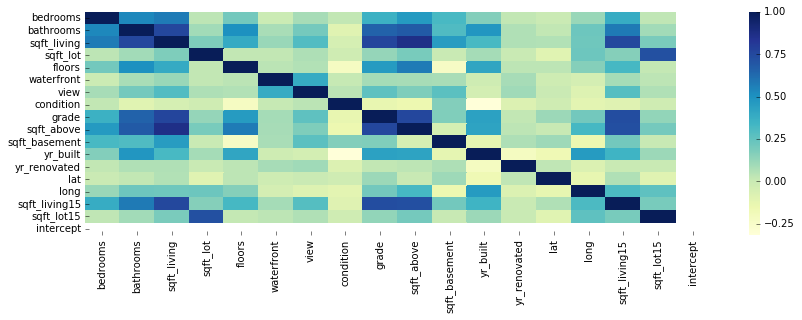

In [12]:
import seaborn as sns

corr = pd.DataFrame.corr(df_scaled_train)

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="YlGnBu")

plt.show()

Como podemos apreciar el indice de correlacion entre **sqft_living** y **sqft_above** es $r=0.868037$ mientras que con la variable **sqft_basement** no es tan alto ($r=0.457049$), esto quizás ya que en su mayoria las casas no poseen sotano. Sin embargo también podemos notar que el indice de correlación entre esta variable es alto con otros predictores como **bathrooms** con un $r=0.760464$, **grade** con un $r= 0.766096$ y **sqft_living15** con un $r=0.754939$.

Como podemos ver el supuesto de de que todas las variables son independientes se cae al ver la matriz de correlación, ya que todos los valores deberian ser cercanos a 0 y aquí tenemos varios coeficientes que estan cerca de $0.5$ o incluso lo sobrepasan como el caso de **sqft_living**. Para solucionar este problema se realizará nuevamente el *fitting* y se realizará el calculo de los Z score sin considerar la variable **sqft_living**.

In [13]:
df2 = df
df2 = df2.drop(["sqft_living"],axis=1)
X = df2
y2 = np.log(df2['price'])
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain2 = X[istrain]
ytrain2 = y[istrain]
Xtest2 = X[np.logical_not(istrain)]
ytest2 = y[np.logical_not(istrain)]
Xtrain2 = Xtrain2.drop(['price'], axis=1)
Xtest2 = Xtest2.drop(['price'], axis=1)
scaler2 = StandardScaler().fit(Xtrain2)
df_scaled_train2 = pd.DataFrame(scaler2.transform(Xtrain2), columns=Xtrain2.columns)
df_scaled_train2.insert(df_scaled_train2.shape[1], 'intercept', np.ones(df_scaled_train2.shape[0]))

linreg.fit(df_scaled_train2, ytrain2)
z_score2 = zscore(df_scaled_train2.as_matrix(),linreg.coef_,df_scaled_train2.std())
d2 = {'1. Nombre_regresor' : df_scaled_train2.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score2)}
print(pd.DataFrame(d2))

print(df_scaled_train2.shape)

   1. Nombre_regresor  2. Coeficientes  3. z-score
0            bedrooms        -0.008086   -0.771117
1           bathrooms         0.055111    3.724857
2            sqft_lot         0.022873    1.930916
3              floors         0.035505    3.118415
4          waterfront         0.033366    3.757811
5                view         0.042595    4.419879
6           condition         0.046360    5.219470
7               grade         0.184577   12.216620
8          sqft_above         0.096628    5.358861
9       sqft_basement         0.060561    5.252478
10           yr_built        -0.104759   -8.587932
11       yr_renovated         0.015266    1.751052
12                lat         0.187880   21.804983
13               long        -0.004031   -0.404072
14      sqft_living15         0.084412    5.990017
15         sqft_lot15        -0.007149   -0.596438
16          intercept        13.033501         inf
(15129, 17)


Como podemos ver el efecto que tiene el quitar esta variable es bastante significativo, ahora los valores de los coeficientes y Z score no presentan ningun valor atípico.

## f) K-fold cross-Validation

El sobreajuste es una complicación que poseen la mayoria de algoritmos de Machine Learning, la cual consiste en ajustarse a caracteristicas muy especificas de los datos de entrenamiento provocando que el modelo pierda la capacidad de generalización. Una forma de evitar este problema es realizar una validación cruzadada de los datos antes de aceptar el modelo.

Para este item se usara el metodo de K-fold cross-validation con $k=5$ y $k=10$ respectivamente.

In [14]:
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)
#Se normaliza la data de test
x_test = pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns)
#Se agrega la columna "intercept"
x_test.insert(x_test.shape[1], 'intercept', np.ones(x_test.shape[0]))
yhat_test = linreg.predict(x_test)
#Error estandar promedio cuadrado
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print("Error estandar promedio", mse_test)
from sklearn.model_selection import KFold
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

Error estandar promedio 0.0652592512372625


In [15]:
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler = StandardScaler().fit(Xm[train])
    df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),columns=Xtrain.columns)
    df_cross_train.insert(df_cross_train.shape[1], 'intercept',np.ones(df_cross_train.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train, ym[train])
    #Se normalizan los datos de test
    df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[val]),columns=Xtrain.columns)
    df_cross_test.insert(df_cross_test.shape[1], 'intercept', np.ones(df_cross_test.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val = linreg.predict(df_cross_test)
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    #print("Error del fold", mse_fold)
    mse_cv += mse_fold
mse_cv = mse_cv/10
print("Error promedio para k=10 ", mse_cv)

Error promedio para k=10  0.0646669893869


In [16]:
kf5 = KFold(n_splits=5)
mse_cv_k5 = 0
for train_k5, val_k5 in kf5.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler_k5 = StandardScaler().fit(Xm[train_k5])
    df_cross_train_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[train_k5]),columns=Xtrain.columns)
    df_cross_train_k5.insert(df_cross_train_k5.shape[1], 'intercept',np.ones(df_cross_train_k5.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train_k5, ym[train_k5])
    #Se normalizan los datos de test
    df_cross_test_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[val_k5]),columns=Xtrain.columns)
    df_cross_test_k5.insert(df_cross_test_k5.shape[1], 'intercept', np.ones(df_cross_test_k5.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val_k5 = linreg.predict(df_cross_test_k5)
    mse_fold_k5 = np.mean(np.power(yhat_val_k5 - ym[val_k5], 2))
    #print("Error del fold", mse_fold_k5)
    mse_cv_k5 += mse_fold_k5
mse_cv_k5 = mse_cv/5
print("Error promedio para k=5 ", mse_cv_k5)

Error promedio para k=5  0.0129333978774


Como podemos ver el valor $MSE$ entregado por las pruebas de validacion cruzada usando *k-folds*, arrojan valores bastante pequeños, si bien es cierto que el error obtenido en $k=5$ es varias veces menor que el obtenido en $K=10$ conserva el mismo orden de magnitud y la explicacion a esta disminución está sujeta al tamaño de los conjuntos usados para hacer la validación cruzada, por lo que al usar un k menor los conjuntos son mas grandes y es esperable la obtencion de un mejor resultado. Para este caso en particular como la diferencia es alrededor de $5\%$ y no se tiene evidencia adicional, concluimos que el modelo **no** tiene sobreajuste.

## j) Análisis del error y normalidad de los datos

In [17]:
import scipy.stats as stats
from scipy.stats import norm

Primero realizaremos la prueba usando el *dataframe* de entrenamiento que tiene la variable **sqft_living** donde obtenemos la sguientes gráficas:

In [18]:
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)
# se calcula la prediccion hecha por el modelo del target usando los datos de entrenamiento.
Xtrain_qq = np.array(df_scaled_train)
yhat_train = linreg.predict(Xtrain_qq)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e = np.array(ytrain) - yhat_train

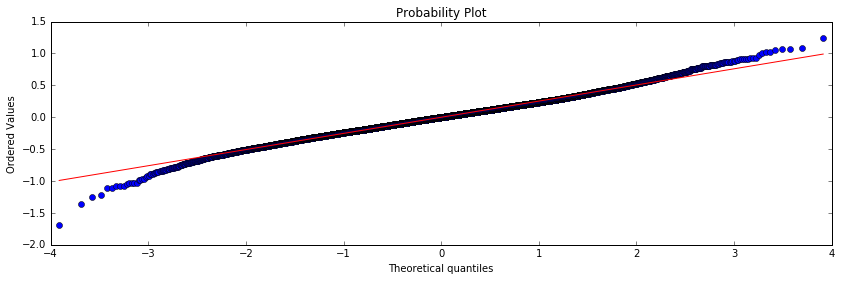

In [19]:
#Se realiza un grafico de probabilidad, el cual nos entregara el mismo resultado que un QQplot ya que n es grande.
stats.probplot(e, dist="norm", plot=plt)
plt.show()

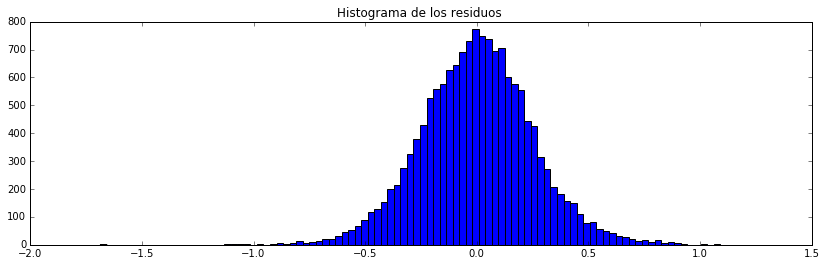

In [20]:
plt.title("Histograma de los residuos ")
plt.hist(e,bins=100)
plt.show()

Como podemos ver los datos en el QQplot se ve bastante bien excepto por los ordenes de magnitud de los ejes. por otro lado mirando el histograma de los residuos podemos apreciar que la concentracion de datos esta un poco inclinada hacia el lado derecho.

Ahora realizaremos las pruebas usando los datos de entenamiento sin la variable **sqft_living**:

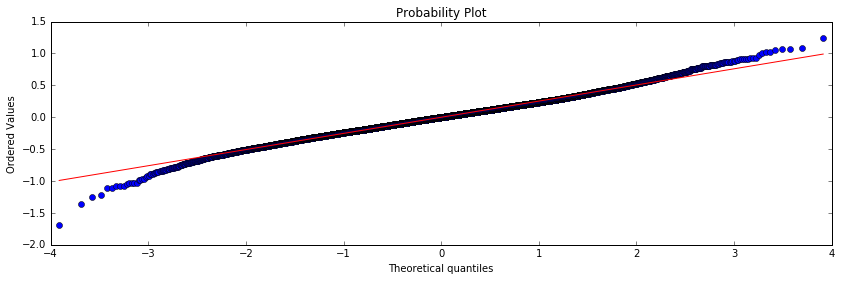

In [21]:
#linreg.fit(df_scaled_train, ytrain)
Xtrain2 = np.array(df_scaled_train2)
linreg.fit(Xtrain2,ytrain2)
yhat_train2 = linreg.predict(Xtrain2)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e2 = np.array(ytrain2) - yhat_train2
stats.probplot(e2, dist="norm", plot=plt)
plt.show()

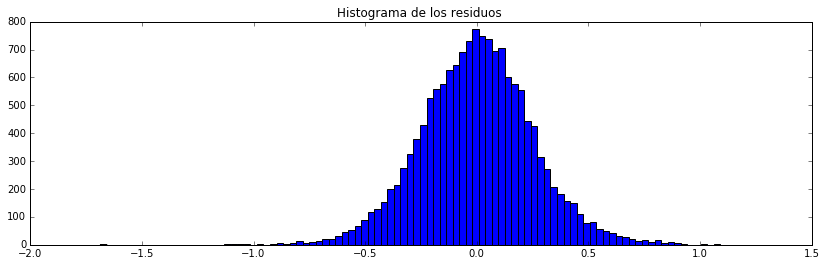

In [22]:
plt.title("Histograma de los residuos ")
plt.hist(e2,bins=100)
plt.show()

podemos ver claramente como mejora el ajuste de los datos en el QQplot y ver como la distribucion de los datos es practicamente una campana de Gauss. 
Viendo todo esto podemos concluir que la hipotesis de normalidad de los residuos del modelo es bastante aceptable.

## h) Comparacion de Modelos

In [23]:
df_A = df.sample(3000)
frames = []
valor = np.log(df.price)
for z in np.arange(int(np.min(valor)),int(np.max(valor))+1,0.5):
    frames.append(df[(np.log(df.price) >= z) & (np.log(df.price) < z+0.5)].head(500))
df_B = pd.concat(frames).sample(3000)
X_A = df_A.iloc[:,1:].values
y_A = df_A.price
X_B = df_B.iloc[:,1:].values
y_B = df_B.price
from sklearn.model_selection import train_test_split
Xtrain_A, Xval_A, ytrain_A, yval_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
Xtrain_B, Xval_B, ytrain_B, yval_B = train_test_split(X_B, y_B, test_size=0.3, random_state=42)

In [24]:
#Analisis para el modelo A
modeloA = linreg.fit(Xtrain_A,ytrain_A)
yhat_A = modeloA.predict(Xval_A)
residuos_A = yhat_A - yval_A
#Analisis para el modelo B
modeloB = linreg.fit(Xtrain_B,ytrain_B)
yhat_B = modeloB.predict(Xval_B)
residuos_B = yhat_B - yval_B

#Se obtiene su R^2
print("R^2 modelo B: ",modeloB.score(Xval_B,yval_B))
print("R^2 modelo A: ",modeloA.score(Xval_A,yval_A))

R^2 modelo B:  0.785078282387
R^2 modelo A:  0.637636302261


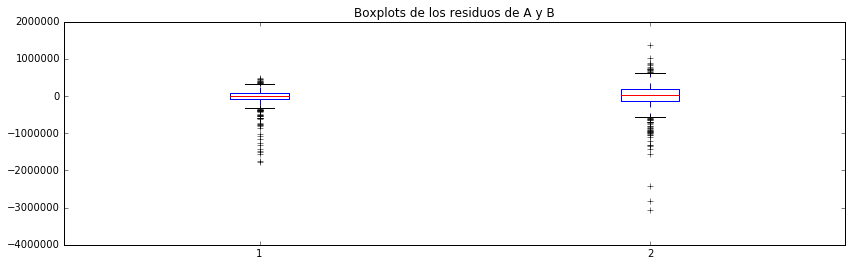

In [25]:
#data = [yhat_A,yhat_B]
data = [residuos_A,residuos_B]
plt.title("Boxplots de los residuos de A y B")
plt.boxplot(data)
plt.show()

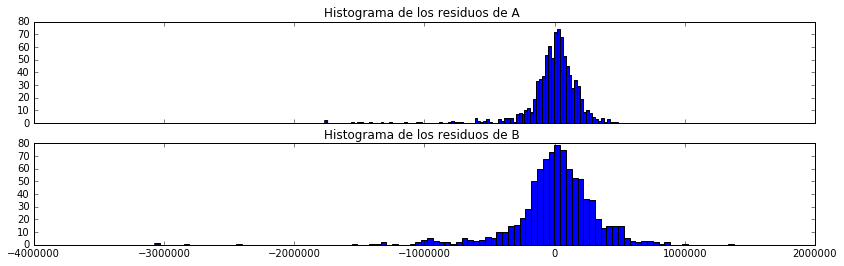

In [26]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(residuos_A,bins=100)
axarr[0].set_title("Histograma de los residuos de A ")
axarr[1].hist(residuos_B,bins=100)
axarr[1].set_title("Histograma de los residuos de B ")
plt.show()

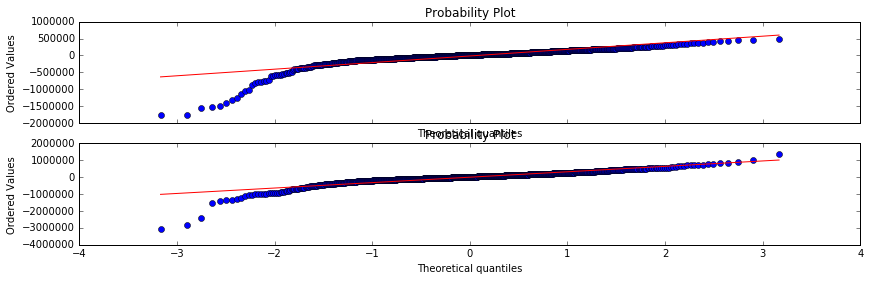

In [27]:
f, axarr = plt.subplots(2, sharex=True)
stats.probplot(residuos_A, dist="norm", plot=axarr[0])
stats.probplot(residuos_B, dist="norm", plot=axarr[1])
plt.show()

Como podemos apreciar a simple vista tenemos que el modelo B posee un mayor $R^2$, tambien notamos que al ver el histograma de los residuos y sus respectivos boxplot que la varianza es mayor en B y ambos poseen una gran cantidad de *outliers*. Ahora viendo el grafico de probabilidad podemos y apoyandonos tambien en el histograma podemos ver que ambos modelos tienen una distribucion bastente "normal", ajustandose el modelo B un poco mejor.

In [28]:
zscoreA = zscore(Xtrain_A,modeloA.coef_, Xtrain_A.std())
dA = {'1. Nombre_regresor' : pd.Series(),'2. Coeficientes' : pd.Series(modeloA.coef_),'3. z-score': pd.Series(z_score)}
print(pd.DataFrame(dA))

    1. Nombre_regresor  2. Coeficientes  3. z-score
0                  NaN    -53376.391203   -0.779803
1                  NaN     87187.909641         NaN
2                  NaN       169.191965         NaN
3                  NaN        -0.273475    1.953327
4                  NaN    -53074.665464         NaN
5                  NaN    687414.349518    3.758568
6                  NaN     47030.743091    4.429731
7                  NaN     14187.076356    5.238076
8                  NaN    131528.014689   12.216285
9                  NaN       117.714350         NaN
10                 NaN        51.477615         NaN
11                 NaN     -4938.920648   -8.780313
12                 NaN        17.730425    1.761846
13                 NaN    418192.054731   21.919739
14                 NaN     90951.452003   -0.404539
15                 NaN        -1.925639   12.041411
16                 NaN        -1.062655   -0.599201
17                 NaN              NaN         inf


C:\Users\Boti\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in sqrt


# 2. Seleccion de atributos

Se usará para la seleccion de atributos el algoritmo Forward Step-wise Selection (FSS), donde primero se usará como criterio de selección el **error cuadrático medio (MSE)**. Posteriormente se seguirá usando este algoritmo pero se cambiará el criterio de seleccion por el **coeficiente de determinacion ajustado** o ($R^2$ Adjusted).

A continuación se presenta el código necesario y los resultados obtenidos.

In [29]:
names_regressors = ["bedrooms","bathrooms","sqft_lot","floors","waterfront","view",
"condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","lat-long",
"sqft_living15","sqft_lot15","intercept"]

Xm = df_scaled_train2.as_matrix()
Ym = ytrain2.as_matrix()
x_test = pd.DataFrame(scaler2.transform(Xtest2),columns=Xtest2.columns)
x_test.insert(x_test.shape[1], 'intercept', np.ones(x_test.shape[0]))
x_test = x_test.as_matrix()
y_test = ytest2

In [30]:
def fss_mse(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(range(0, p))
    selected = [p]
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("selected = %s    ...    "%names_x[best_candidate], "totalvars=%d, mse = %f"%(len(indexes),best_new_score))
    return selected

orden_variables_mse = fss_mse(Xm,Ym,names_regressors)

selected = sqft_living15    ...     totalvars=2, mse = 0.277003
selected = yr_built    ...     totalvars=3, mse = 0.276593
selected = condition    ...     totalvars=4, mse = 0.275049
selected = intercept    ...     totalvars=5, mse = 0.272870
selected = sqft_lot    ...     totalvars=6, mse = 0.272046
selected = yr_renovated    ...     totalvars=7, mse = 0.265722
selected = waterfront    ...     totalvars=8, mse = 0.258152
selected = view    ...     totalvars=9, mse = 0.235387
selected = sqft_basement    ...     totalvars=10, mse = 0.220136
selected = bedrooms    ...     totalvars=11, mse = 0.205304
selected = floors    ...     totalvars=12, mse = 0.175517
selected = bathrooms    ...     totalvars=13, mse = 0.156167
selected = sqft_above    ...     totalvars=14, mse = 0.123111
selected = sqft_lot15    ...     totalvars=15, mse = 0.112277
selected = grade    ...     totalvars=16, mse = 0.095945
selected = lat-long    ...     totalvars=17, mse = 0.064516


In [31]:
def fss_r2(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(range(0, p))
    selected = [p]
    current_score = 0.0
    best_new_score = 0.0
    error=[]
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            model.fit(x_train,y)
            predictions_train = model.predict(x_train)
            r2 = model.score(x_train,y)
            N = x_train.shape[0]
            P = x_train.shape[1]
            r2adjusted = r2- (1 -r2)*P/(N-P-1)
            score_candidates.append((r2adjusted, candidate))
        score_candidates.sort()
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("selected = %s    ...   "%names_x[best_candidate], "totalvars=%d, r2adjusted = %f"%(len(indexes),best_new_score))
    return selected

orden_variables_r2 = fss_r2(Xm,Ym,names_regressors)

selected = grade    ...    totalvars=2, r2adjusted = 0.483591
selected = lat-long    ...    totalvars=3, r2adjusted = 0.627466
selected = yr_built    ...    totalvars=4, r2adjusted = 0.664197
selected = bathrooms    ...    totalvars=5, r2adjusted = 0.705303
selected = sqft_lot15    ...    totalvars=6, r2adjusted = 0.730689
selected = view    ...    totalvars=7, r2adjusted = 0.742771
selected = condition    ...    totalvars=8, r2adjusted = 0.748261
selected = sqft_above    ...    totalvars=9, r2adjusted = 0.754417
selected = sqft_basement    ...    totalvars=10, r2adjusted = 0.759286
selected = waterfront    ...    totalvars=11, r2adjusted = 0.762875
selected = floors    ...    totalvars=12, r2adjusted = 0.765196
selected = sqft_lot    ...    totalvars=13, r2adjusted = 0.766272
selected = yr_renovated    ...    totalvars=14, r2adjusted = 0.766984
selected = bedrooms    ...    totalvars=15, r2adjusted = 0.767102
selected = intercept    ...    totalvars=16, r2adjusted = 0.767184
selected 

In [32]:
def error(orden,names,X,y,Xt, yt):
    l = []
    l2 = []
    mse = []
    mse2 = []
    model = lm.LinearRegression(fit_intercept=False)
    for i in range(X.shape[1]):
        l.append(X[:,orden[i]])
        l2.append(Xt[:,orden[i]])
        M = np.transpose(l)
        M2 = np.transpose(l2)
        model.fit(M,y)
        yhat = model.predict(M)
        yhat2 = model.predict(M2)
        mse.append(np.mean(np.power(yhat-y,2)))
        mse2.append(np.mean(np.power(yhat2-yt,2)))
    return mse, mse2

In [33]:
train_error_mse, test_error_mse = error(orden_variables_mse,names_regressors,Xm,Ym,x_test,y_test)
train_error_r2, test_error_r2 = error(orden_variables_r2,names_regressors,Xm,Ym,x_test,y_test)

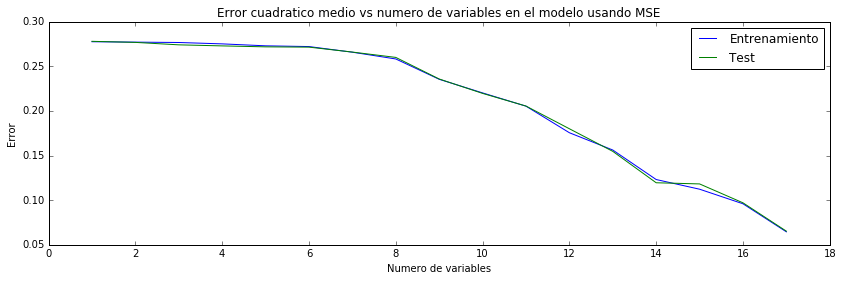

In [34]:
x = np.arange(17)
plt.title("Error cuadratico medio vs numero de variables en el modelo usando MSE")
plt.plot(x+1,train_error_mse,color="b",label="Entrenamiento")
plt.plot(x+1,test_error_mse,color = "g",label = "Test")
plt.ylabel("Error")
plt.xlabel("Numero de variables")
plt.legend(loc="upper right")
plt.show()

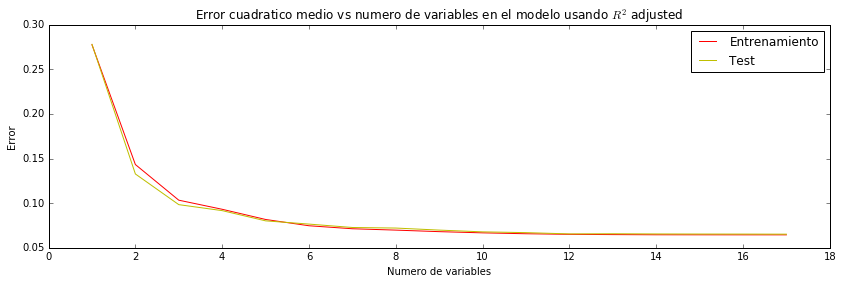

In [35]:
plt.title("Error cuadratico medio vs numero de variables en el modelo usando $R^2$ adjusted")
x = np.arange(17)
plt.plot(x+1,train_error_r2,color="r", label="Entrenamiento")
plt.plot(x+1,test_error_r2,color = "y", label = "Test")
plt.ylabel("Error")
plt.xlabel("Numero de variables")
plt.legend(loc="upper right")
plt.show()

Como podemos apreciar en ambas gráficas, el error cuadrático medio de los datos de entrenamiento y de prueba es bastante parecido, esto quire decir que el modelo no posee sobreajuste a medida que agregamos nuevas características a nuestro modelo, pudiendo predecir de forma esperada los valores de nuestro target ($y$). Otro punto importante es que, al hacer la comparación entre los criterios, podemos notar que al usar como criterio de seleccion $MSE$, se requiere una mayor cantidad de variables para bajar el error de forma considerable, mientras que al usar el criterio de seleccion $R^2$ ajustado notamos que el error disminuye mucho mas rapido y tiende a estabilizarse alrededor de las 7 variables. Finalmente, vale mencionar que ambos criterios van a entregar un orden distinto de características, pero en general, las características más importantes se mantienen en ambos conjuntos.

## 3. Regularización: Ridge Regression y Lasso

Con tal de generar un modelo lineal para nuestro problema que logre evitar sobreajustes, se probarán las técnicas de regularización: Ridge Regression y Lasso. Se harán pruebas con variados valores de *alpha* (parámetro para cada algoritmo, que define la penalización a cada atributo de menor importancia al modelo), y se verá cómo cambian los coeficientes de cada característica a medida que cambia este *alpha*.

In [36]:
X = df
X = X.drop(["sqft_living"],axis=1)
y = np.log(X["price"])
X = X.drop(["price"],axis=1)

mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
X_reg_train = X[istrain]
y_reg_train = y[istrain]
X_reg_test = X[np.logical_not(istrain)]
y_reg_test = y[np.logical_not(istrain)]

scaler_reg_train = StandardScaler().fit(X_reg_train)
X_reg_train = pd.DataFrame(scaler_reg_train.transform(X_reg_train), columns=X_reg_train.columns)
X_reg_train.insert(X_reg_train.shape[1], 'intercept', np.ones(X_reg_train.shape[0]))

scaler_reg_test = StandardScaler().fit(X_reg_test)
X_reg_test = pd.DataFrame(scaler_reg_test.transform(X_reg_test), columns=X_reg_test.columns)
X_reg_test.insert(X_reg_test.shape[1], 'intercept', np.ones(X_reg_test.shape[0]))

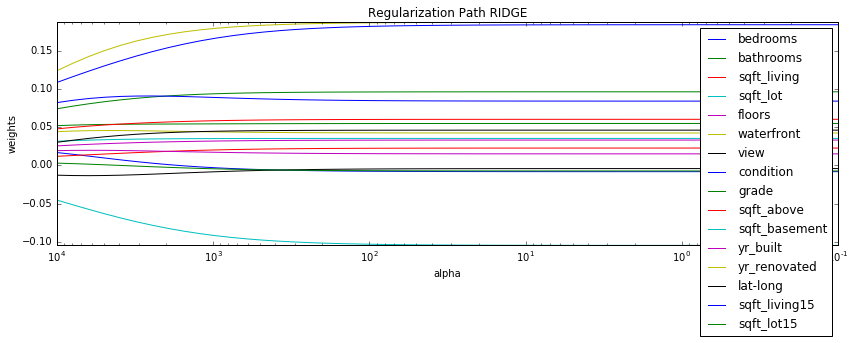

In [37]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt

X_reg_train = X_reg_train.drop('intercept', axis=1)
X_reg_test = X_reg_test.drop('intercept', axis=1)
names_regressors = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view",
"condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","lat-long",
"sqft_living15","sqft_lot15"]
alphas_ = np.logspace(4,-1,base=10)
coefs = []


model = Ridge(fit_intercept=True, solver='svd') # Se utiliza SVD para obtener los coeficientes
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_reg_train, y_reg_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=1)
plt.show()

In [38]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(fit_intercept=True, gcv_mode='svd')
model.fit(X_reg_train, y_reg_train)
print("Mejor alpha es: ", model.alpha_)
print("R^2 es: ", model.score(X_reg_test, y_reg_test))
print("MSE es: ", np.mean(np.power(model.predict(X_reg_test) - y_reg_test, 2)))

Mejor alpha es:  10.0
R^2 es:  0.756475383808
MSE es:  0.0671221743090362


Podemos ver que Ridge Regression, en general, reduce o penaliza los pesos de las características menos importantes (las de menor varianza, acercándolas a cero). Esta penalización aumenta a medida que aumenta el valor de *alpha*, sin embargo, en este caso las penalizaciones van a ser similares para valores bajos de *alpha*, y sólo con valores extremadamente altos, las penalizaciones serán mayores.

Utilizando RidgeCV, podemos inmediatamente realizar pruebas de cross-validation para encontrar el mejor *alpha*, que en este caso, es $10^1$

Ahora probaremos con Lasso.

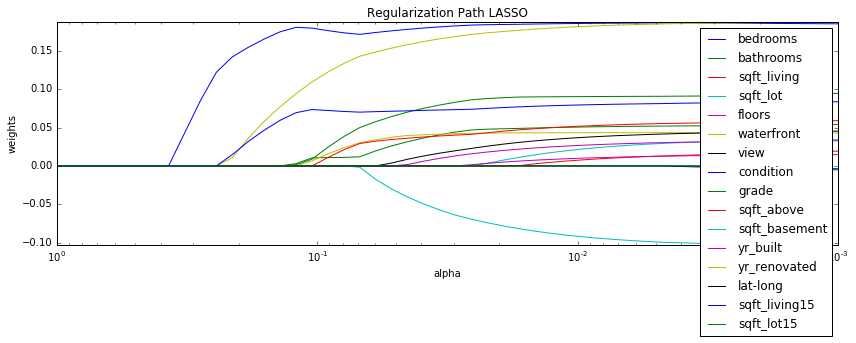

In [39]:
from sklearn.linear_model import Lasso

alphas_ = np.logspace(0,-3,base=10)
coefs = []


model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_reg_train, y_reg_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path LASSO')
plt.axis('tight')
plt.legend(loc=1)
plt.show()

In [40]:
from sklearn.linear_model import LassoCV
model = LassoCV(fit_intercept=True)
model.fit(X_reg_train, y_reg_train)
print("Mejor alpha es: ", model.alpha_)
print("R^2 es: ", model.score(X_reg_test, y_reg_test))
print("MSE es: ", np.mean(np.power(model.predict(X_reg_test) - y_reg_test, 2)))

Mejor alpha es:  0.000366323361348
R^2 es:  0.7565173737
MSE es:  0.06711060072417424


Podemos ver que el caso para Lasso es distinto. Lasso, en general, llega a eliminar los coeficientes de las características de menor varianza (dejandolos como cero), y en este caso mayor sea *alpha*, más características serán eliminadas. Esto permite que Lasso también sea usado como un método de selección de características (*Feature Selection*), si se hacen las pruebas de cross-validation (CV) adecuadas.

Al igual que Ridge, el ajuste del parámetro *alpha* se puede ver como un problema en sí, y va a afectar el rendimiento del modelo. Podemos graficar el caso de Lasso con varios valores de *alpha* y ver qué ocurre.

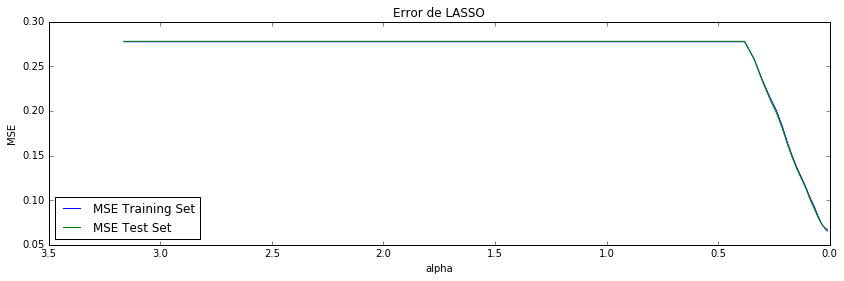

In [41]:
alphas_list = np.logspace(0.5,-2,base=10)
mse_train = []
mse_test = []
for i in alphas_list:
    model_graph = Lasso(alpha = i, fit_intercept = True)
    model_graph.fit(X_reg_train, y_reg_train)
    mse_train.append(np.mean(np.power(model_graph.predict(X_reg_train) - y_reg_train, 2)))
    mse_test.append(np.mean(np.power(model_graph.predict(X_reg_test) - y_reg_test, 2)))

plt.plot(alphas_list, mse_train, color = "b", label = "MSE Training Set")
plt.plot(alphas_list, mse_test, color = "g", label = "MSE Test Set")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Error de LASSO')
plt.legend(loc=3)
plt.gca().invert_xaxis() # reverse axis
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression
model_ls = LinearRegression(fit_intercept = True)
model_ls.fit(X_reg_train, y_reg_train)
print(model_ls.score(X_reg_train, y_reg_train))
print(model_ls.score(X_reg_test, y_reg_test))

0.767469483196
0.756474075258


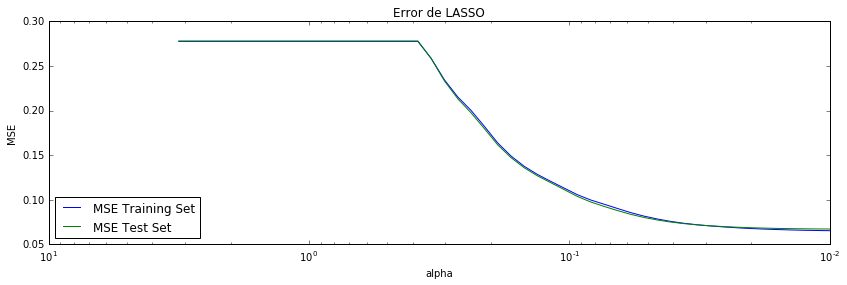

In [43]:
plt.plot(alphas_list, mse_train, color = "b", label = "MSE Training Set")
plt.plot(alphas_list, mse_test, color = "g", label = "MSE Test Set")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Error de LASSO')
plt.legend(loc=3)
plt.gca().invert_xaxis() # reverse axis
plt.gca().set_xscale('log')
plt.show()

Podemos notar que con un *alpha* igual o mayor a $\approx 0.4$, el error cuadrático medio se estanca para ambos casos (con *set* de entramiento y set de pruebas), sin embargo, con valores menores comienza a reducirse.

Utilizando cross-validation mediante LassoCV (usando el mismo *set* de entrenamiento, y CV tipo 3-fold) obtenemos que el mejor *alpha* es aproximadamente $0.000366323361348 \approx 10^{-4}$. Sin embargo, también podemos buscar un mejor *alpha* usando 10-fold CV, y usando un menor MSE como medida de evaluación.

In [44]:
from sklearn.linear_model import Lasso
MSE = lambda y,yhat: np.mean(np.power(y-yhat,2))
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(Xm),10)
best_cv_mse = float("inf")
model = Lasso(fit_intercept=True)
mse_list_k10 = []
alphas_list = []
best_mse_list = []
for a in alphas_:
    model.set_params(alpha=a)
    for train,vald in k_fold:
        cross_scaler = StandardScaler().fit(Xm[train])
        df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),
        columns=Xtrain.columns)
        df_cross_train.insert(df_cross_train.shape[1], 'intercept',
        np.ones(df_cross_train.shape[0]))
        df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[vald]),
        columns=Xtrain.columns)
        df_cross_test.insert(df_cross_test.shape[1], 'intercept',
        np.ones(df_cross_test.shape[0]))
        mse_list_k10.append(MSE(model.fit(df_cross_train, ym[train]).predict(df_cross_test),ym[vald]))
    if np.mean(mse_list_k10) < best_cv_mse:
        best_cv_mse = np.mean(mse_list_k10)
        best_alpha = a
        alphas_list.append(a)
        best_mse_list.append(best_cv_mse)
        print("Mejor alpha es: ", best_alpha, " , MSE(CV) es: " , best_cv_mse)

C:\Users\Boti\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Mejor alpha es:  1.0  , MSE(CV) es:  0.277498496095
Mejor alpha es:  0.568986602902  , MSE(CV) es:  0.277498496095
Mejor alpha es:  0.323745754282  , MSE(CV) es:  0.2739696934
Mejor alpha es:  0.281176869797  , MSE(CV) es:  0.268229377715
Mejor alpha es:  0.244205309455  , MSE(CV) es:  0.261532320448
Mejor alpha es:  0.212095088792  , MSE(CV) es:  0.254161983117
Mejor alpha es:  0.184206996933  , MSE(CV) es:  0.246260895908
Mejor alpha es:  0.159985871961  , MSE(CV) es:  0.238321060662
Mejor alpha es:  0.138949549437  , MSE(CV) es:  0.230590798759
Mejor alpha es:  0.120679264064  , MSE(CV) es:  0.223225427117
Mejor alpha es:  0.104811313415  , MSE(CV) es:  0.216299631015
Mejor alpha es:  0.0910298177992  , MSE(CV) es:  0.209776555616
Mejor alpha es:  0.0790604321091  , MSE(CV) es:  0.203667017863
Mejor alpha es:  0.0686648845004  , MSE(CV) es:  0.197972734083
Mejor alpha es:  0.0596362331659  , MSE(CV) es:  0.192606480831
Mejor alpha es:  0.0517947467923  , MSE(CV) es:  0.187552263023


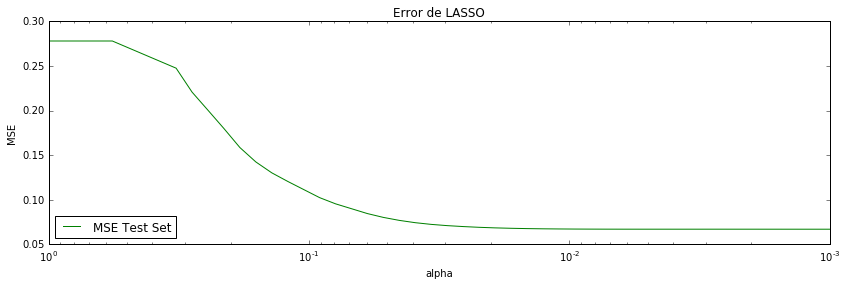

In [45]:
n_iter = []
mse_test = []
for i in alphas_list:
    model_graph = Lasso(alpha = i, fit_intercept = True)
    model_graph.fit(X_reg_train, y_reg_train)
    n_iter.append(model_graph.n_iter_)
    mse_test.append(np.mean(np.power(model_graph.predict(X_reg_test) - y_reg_test, 2)))

plt.plot(alphas_list, mse_test, color = "g", label = "MSE Test Set")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Error de LASSO')
plt.legend(loc=3)
plt.gca().invert_xaxis() # reverse axis
plt.gca().set_xscale('log')
plt.show()

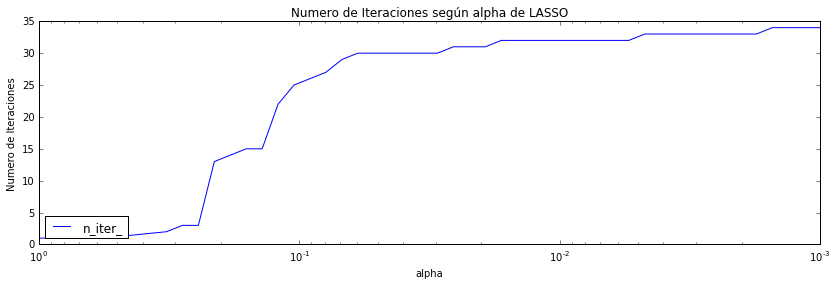

In [46]:
plt.plot(alphas_list, n_iter, color = "b", label = "n_iter_")
plt.xlabel('alpha')
plt.ylabel('Numero de Iteraciones')
plt.title('Numero de Iteraciones según alpha de LASSO')
plt.legend(loc=3)
plt.gca().invert_xaxis() # reverse axis
plt.gca().set_xscale('log')
plt.show()

Podemos darnos cuenta que en este caso, un test de CV nos indica que el MSE promedio va bajando a medida que reducimos *alpha*, sin embargo, esto tiene un costo asociado: el número de iteraciones de Lasso va en aumento, lo que hace que el tiempo de ejecución vaya subiendo. Según la aplicación de nuestro análisis, puede que intentemos buscar el mejor *alpha* para minimizar el MSE de nuestro modelo en general, e intentar maximizar nuestro $R^2$, pero hay que recordar que existen otros factores importantes, como son el tiempo de ejecución, el uso de memoria y el nivel de generalización que vayamos a obtener con el modelo.

## 4. Análisis del data set de películas: Movie$ Data Corpus

A continuación se hará un análisis del dataset "Movie$ Data Corpus". Este conjunto tiene 145256 características, debido a todas las combinaciones de palabras posibles de las críticas/reviews de cada película. Por lo tanto, se debe tratar con herramientas hechas para matrices *sparse*.

### a. Análisis Inicial

Son 1147 elementos de entrenamiento, 254 elementos de prueba, y 317 elementos para el cross-validation.

Se comenzará cargando los datos.

In [47]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
from scipy.io import mmread
from sklearn.metrics import mean_squared_error


#X_movies = pd.SparseDataFrame( csr_matrix(mmread('train.x.mm')) )
X_movies = csc_matrix(mmread('train.x.mm'))
y_movies = np.loadtxt('train.y.dat')
X_movies_dev = csc_matrix(mmread('dev.x.mm'))
y_movies_dev = np.loadtxt('dev.y.dat')
X_movies_test = csc_matrix(mmread('test.x.mm'))
y_movies_test = np.loadtxt('test.y.dat')

Intentando hacer una regresión lineal convencional, obtenemos resultados mediocres con un error muy alto.

In [48]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies, y_movies)
print("Usando regresión lineal ordinaria, sin preprocesamiento, R^2 es: ", model.score(X_movies_test, y_movies_test))
y_movies_pred = model.predict(X_movies_test)
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred))

Usando regresión lineal ordinaria, sin preprocesamiento, R^2 es:  0.590314359229
MSE:  1.9509771333e+14


Antes de probar otros modelos, ya que la variable objetivo será la ganancia de las películas, se hará una **Transformación Logarítmica** a los y.

In [49]:
y_movies = np.log(y_movies)
y_movies_dev = np.log(y_movies_dev)
y_movies_test = np.log(y_movies_test)

Según la documentación de Scikit, no se debe usar estandarización mediante StandardScaler con datos *sparse* debido a que se arruinaría su estructura. Por lo tanto, se recomiendaría usar MaxAbsScaler, el cual hace un *scaling* de cada característica con tal de que el valor máximo de cada una sea 1.0. Vamos a intentar realizar *scaling* con este preprocesador.

In [50]:
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import hstack


scaler_movies = MaxAbsScaler().fit(X_movies) # Para matriz sparse
X_scaled_movies_train = scaler_movies.transform(X_movies)

# Se ingresa columna de unos, que son los pesos o coeficientes del primer parametro (el intercepto, beta_0)
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_train.shape[0])[:, None])
X_scaled_movies_train = hstack((X_scaled_movies_train, matriz_de_unos))

model_movies = lm.LinearRegression(fit_intercept = False)
model_movies.fit(X_scaled_movies_train, y_movies)

#scaler_movies_test = MaxAbsScaler().fit(X_movies_test) # Para matriz sparse
X_scaled_movies_test = scaler_movies.transform(X_movies_test)
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_test.shape[0])[:, None])
X_scaled_movies_test = hstack((X_scaled_movies_test, matriz_de_unos))
r2_2 = model_movies.score(X_scaled_movies_test, y_movies_test)

print("Usando regresión lineal ordinaria, con estandarizacion MaxAbsScaler, R^2 es: ", r2_2)
print("MSE: ", mean_squared_error(y_movies_test, model_movies.predict(X_scaled_movies_test)))

Usando regresión lineal ordinaria, con estandarizacion MaxAbsScaler, R^2 es:  0.362029825727
MSE:  7.09634213212


La regresión lineal presenta un peor rendimiento, pero al menos el error cuadrático medio es más legible.

### b. Feature Selection

Debido a que tenemos demasiadas características, vamos a intentar hacer **Feature Selection**.

Se comenzará con un algoritmo de selección simple: VarianceThreshold, el cual elimina las características que tengan una varianza menor a cierto *threshold*.

Pensando en que este dataset tiene muchas variables binarias, si es que queremos eliminar las variables que tienen el mismo valor en 95% de las muestras, podemos obtener este *threshold* de la varianza usando la fórmula de varianza de la función de Bernoulli:

$$Var[X] = p (1-p)$$

Probaremos con $p = 0.95$

In [51]:
from sklearn.feature_selection import VarianceThreshold

var_threshold = (.95 * (1 - .95))
sel = VarianceThreshold(threshold=var_threshold)
X_movies_fs_var = sel.fit_transform(X_scaled_movies_train)
X_movies_test_fs_var = sel.transform(X_scaled_movies_test)

In [52]:
print(X_movies_fs_var.shape)
print(X_movies_test_fs_var.shape)

(1147, 193)
(254, 193)


Con esta selección sólo quedan 193 variables.

In [53]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies_fs_var, y_movies)
print("Usando regresión lineal ordinaria, al usar feat. selection, R^2 es: ", model.score(X_movies_test_fs_var, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, model.predict(X_movies_test_fs_var)))

Usando regresión lineal ordinaria, al usar feat. selection, R^2 es:  0.754234300908
MSE:  2.73372887233


In [54]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], ", ", end='')

Numero de atributos que quedaron con pesos no nulos:  193
VV_choke , VV_being , NY_crime , VV_himself , NY_producer , VV_de , EW_fake , VV_appear , NY_<TOKNUM> , VA_gangster , NY_pervasive , NY_hard , NY_states , VV_deep , VA_more , NY_clear , VV_neighborhood , VV_spite , NY_imperative , NY_rape , NY_exposition , NY_diabolical , VV_story , NY_silent , VA_rep , VA_relationship , VA_iffy , VV_crazy , NY_age , VA_topic , NY_together , VA_plot , VA_joey , EW_high , NY_tina , NY_neighborhood , NY_insist , NY_class , NY_persian , EW_knockoff , NY_touch , VA_implication , NY_time , NY_relish , NY_not , VA_court , VA_tech , NY_agent , NY_connect , NY_only , VV_join , VV_marsden , VV_up , VV_enable , VV_his , VA_well , VV_knee , VA_all , VA_wolf , VV_mostly , VA_story , VA_thanks , NY_half , VA_storm , VA_philadelphia , VA_informant , VA_rac , NY_women , VV_watch , VV_muck , NY_packed , VA_gulf , VV_blood , EW_face , NY_drug , VA_cousin , VV_returns , NY_city , NY_guy , NY_front , VA_kid , NY_h

Obtuvimos un $R^2$ mejor que antes, pero el error aún es significativo.

Ahora vamos a intentar **Recursive Feature Elimination (RFE)**, lo cual es básicamente ir probando cierto estimador (en este caso, regresión lineal) eliminando variables (características) una en una hasta llegar a cierto número (por defecto, la mitad de las variables iniciales).

Esto es parecido a lo que se hizo anteriormente con FSS (Forward Step Selection). Lamentablemente, ya que tenemos demasiadas características y el costo computacional de RFE es alto, primero se utilizará VarianceThreshold con $p=0.96$, y luego se ejecutará RFE para seleccionar 100 características.

In [55]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

var_threshold = (.96 * (1 - .96))
sel_1 = VarianceThreshold(threshold=var_threshold)
X_movies_fs_var = sel_1.fit_transform(X_scaled_movies_train)
X_movies_test_fs_var = sel_1.transform(X_scaled_movies_test)

print(X_movies_fs_var.shape)
print(X_movies_test_fs_var.shape)

sel_2 = RFE(lm.LinearRegression(fit_intercept = False), n_features_to_select=100)

X_movies_fs_kb = sel_2.fit_transform(X_movies_fs_var, y_movies)
X_movies_test_fs_kb = sel_2.transform(X_movies_test_fs_var)

print(X_movies_fs_kb.shape)
print(X_movies_test_fs_kb.shape)

(1147, 429)
(254, 429)
(1147, 100)
(254, 100)


In [56]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies_fs_kb, y_movies)
print("Usando regresión lineal ordinaria, al usar feat. selection, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, model.predict(X_movies_test_fs_kb)))

Usando regresión lineal ordinaria, al usar feat. selection, R^2 es:  0.756473655381
MSE:  2.70881983091


In [57]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], ", ", end='')

Numero de atributos que quedaron con pesos no nulos:  100
VV_choke , VV_being , NY_crime , VV_himself , NY_producer , VV_de , EW_fake , VV_appear , NY_<TOKNUM> , VA_gangster , NY_pervasive , NY_hard , NY_states , VV_deep , VA_more , NY_clear , VV_neighborhood , VV_spite , NY_imperative , NY_rape , NY_exposition , NY_diabolical , VV_story , NY_silent , VA_rep , VA_relationship , VA_iffy , VV_crazy , NY_age , VA_topic , NY_together , VA_plot , VA_joey , EW_high , NY_tina , NY_neighborhood , NY_insist , NY_class , NY_persian , EW_knockoff , NY_touch , VA_implication , NY_time , NY_relish , NY_not , VA_court , VA_tech , NY_agent , NY_connect , NY_only , VV_join , VV_marsden , VV_up , VV_enable , VV_his , VA_well , VV_knee , VA_all , VA_wolf , VV_mostly , VA_story , VA_thanks , NY_half , VA_storm , VA_philadelphia , VA_informant , VA_rac , NY_women , VV_watch , VV_muck , NY_packed , VA_gulf , VV_blood , EW_face , NY_drug , VA_cousin , VV_returns , NY_city , NY_guy , NY_front , VA_kid , NY_h

Logramos llegar a un modelo de sólo 100 características con un R^2 bastante decente, sin embargo, quizás sea necesario utilizar otro algoritmo con tal de llegar a un modelo bueno.

Viendo que nuestra matriz de datos inicial es *sparse*, y buscando la necesidad de no tener que utilizar las 145256 características, vamos a intentar con el estimador Lasso. Comenzaremos con un $\alpha = 0.6$ y tres conjuntos de datos: El original, uno con el *scaling*, y uno que tiene *scaling* y las 100 características obtenidas anteriormente.

In [58]:
# Datos originales

from sklearn.linear_model import Lasso
alpha = 0.6
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_movies, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test)
print("Usando Lasso sin scaling de la data, R^2 es: ", model.score(X_movies_test, y_movies_test))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso sin scaling de la data, R^2 es:  0.823362503132
MSE:  1.9647942203


In [59]:
# Datos con scaling

alpha = 0.6
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_scaled_movies_train, y_movies)
y_movies_pred_lasso = model.predict(X_scaled_movies_test)
print("Usando Lasso con scaling de la data, R^2 es: ", model.score(X_scaled_movies_test, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso con scaling de la data, R^2 es:  0.444710633804
MSE:  6.17665759899


In [60]:
# Datos con scaling y 100 features

alpha = 0.6
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_movies_fs_kb, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test_fs_kb)
print("Usando Lasso con scaling de la data y feat. selection, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso con scaling de la data y feat. selection, R^2 es:  0.444710631903
MSE:  6.17665762014


Al igual que el caso de regresión lineal ordinaria, obtuvimos un peor rendimiento al hacer *scaling*. Pero antes de descartar este preprocesamiento, utilizaremos LassoCV para encontrar un *alpha* mejor.

In [61]:
# Datos con scaling y 100 features, con LassoCV

from sklearn.linear_model import LassoCV
model = LassoCV(tol=0.001)
model.fit(X_movies_fs_kb, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test_fs_kb)
print("Usando LassoCV con scaling de la data, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

alpha_optimo = model.alpha_
print("Alpha optimo obtenido es: ", alpha_optimo)

Usando LassoCV con scaling de la data, R^2 es:  0.857778934138
MSE:  1.58196947514
Alpha optimo obtenido es:  0.00163609684932


Obtuvimos un $\alpha \approx 0.00163609684932$. Intentemos usar este *alpha* en los otros dos casos (datos originales y datos solo con *scaling*)

In [62]:
# Datos originales, alpha optimo

alpha = alpha_optimo
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_movies, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test)
print("Usando Lasso sin scaling de la data, R^2 es: ", model.score(X_movies_test, y_movies_test))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso sin scaling de la data, R^2 es:  0.766890970983
MSE:  2.5929447656


C:\Users\Boti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [63]:
# Datos con scaling, alpha optimo

alpha = alpha_optimo
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_scaled_movies_train, y_movies)
y_movies_pred_lasso = model.predict(X_scaled_movies_test)
print("Usando Lasso con scaling de la data, R^2 es: ", model.score(X_scaled_movies_test, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso con scaling de la data, R^2 es:  0.834952584334
MSE:  1.83587411578


El procesamiento de estos dos casos tarda mucho (con un *timeout* en el caso de los datos originales sin *scaling*), y no logra obtener mejoras significativas en el rendimiento del modelo. Por lo tanto, nos quedaremos con nuestro modelo *scaled* de 100 características con Lasso.

Sin embargo, debemos recordar que Lasso podría haber eliminado alguna de estas 100 variables. Volveremos al caso elegido y verificaremos.

### c. Modelo elegido

In [64]:
# Datos con scaling y 100 features, usando alpha optimo

alpha = alpha_optimo
model = Lasso(alpha=alpha, tol=0.0001)
model.fit(X_movies_fs_kb, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test_fs_kb)
print("Usando Lasso con scaling de la data y feat. selection, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando Lasso con scaling de la data y feat. selection, R^2 es:  0.857820819772
MSE:  1.58150356811


In [65]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
print( "Sus indices son: ", np.nonzero(model.coef_) )
print( "Los coeficientes son: ", model.coef_[np.nonzero(model.coef_)] )

Numero de atributos que quedaron con pesos no nulos:  61
Sus indices son:  (array([ 0,  1,  2,  3,  4,  5, 11, 14, 15, 16, 18, 20, 21, 23, 24, 26, 27,
       28, 29, 31, 34, 35, 37, 38, 39, 42, 43, 45, 48, 50, 52, 53, 55, 56,
       59, 60, 61, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 80, 81, 82, 84,
       85, 86, 88, 89, 92, 93, 95, 96, 97, 98], dtype=int64),)
Los coeficientes son:  [-0.3165251   0.01111254 -0.5767283   0.43088258  0.62695271  0.38241787
 -0.02202423  0.18338901  0.21231609  0.23097705 -0.13600673  0.47121312
 -0.09472101  0.52519087  0.69483648 -0.26852288  0.41809554 -0.0611088
  0.40327172  0.17320653 -0.01225841  0.35030942  0.02106562 -0.87488956
 -0.10832007 -0.26325355 -0.07834724  0.43749891  0.05272507 -0.12207098
  0.02999983 -0.36143319  0.08721171  0.56902943  0.21325997  0.32257353
 -0.45952122 -0.34361018  0.06617758 -1.00243123  0.98048133  0.78240794
  0.07792235 -0.00941924  0.06885636  0.00876904  0.35398595 -0.09985895
  0.53012202 -0.06318387  0.56

Finalmente obtuvimos un modelo lineal de 61 características, las cuales son:

In [66]:
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], "    ", (model.coef_)[i])

VV_choke      -0.316525098684
VV_being      0.0111125378131
NY_crime      -0.576728297295
VV_himself      0.430882579069
NY_producer      0.626952708117
VV_de      0.38241786545
NY_hard      -0.0220242277666
VA_more      0.183389007611
NY_clear      0.212316089313
VV_neighborhood      0.230977054294
NY_imperative      -0.136006730735
NY_exposition      0.471213119739
NY_diabolical      -0.0947210079785
NY_silent      0.525190872079
VA_rep      0.694836481371
VA_iffy      -0.268522883458
VV_crazy      0.418095538887
NY_age      -0.0611088023713
VA_topic      0.403271720276
VA_plot      0.173206531534
NY_tina      -0.0122584130601
NY_neighborhood      0.35030941577
NY_class      0.0210656156058
NY_persian      -0.874889561369
EW_knockoff      -0.108320074257
NY_time      -0.263253551294
NY_relish      -0.0783472436504
VA_court      0.437498906991
NY_connect      0.0527250699229
VV_join      -0.122070980488
VV_up      0.0299998298199
VV_enable      -0.361433189751
VA_well      0.087211708

### d. Cross-validation

Para terminar, haremos pruebas de cross-validation con K-Folds, usando el conjunto "dev" dejado para este fin.

In [67]:
X_scaled_movies_dev = scaler_movies.transform(X_movies_dev)

matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_dev.shape[0])[:, None])
X_scaled_movies_dev = hstack((X_scaled_movies_dev, matriz_de_unos))

X_scaled_movies_dev = sel_1.transform(X_scaled_movies_dev)
X_scaled_movies_dev = sel_2.transform(X_scaled_movies_dev)

from sklearn.model_selection import KFold, cross_val_score

k_fold = KFold(n_splits=5)

print(cross_val_score(Lasso(alpha=alpha_optimo, tol=0.0001), X_scaled_movies_dev, y_movies_dev, cv=KFold(n_splits=5), n_jobs=-1))
print(cross_val_score(Lasso(alpha=alpha_optimo, tol=0.0001), X_scaled_movies_dev, y_movies_dev, cv=KFold(n_splits=10), n_jobs=-1))
print(cross_val_score(Lasso(alpha=alpha_optimo, tol=0.0001), X_scaled_movies_dev, y_movies_dev, cv=KFold(n_splits=15), n_jobs=-1))

[ 0.85973068  0.80912625  0.89023359  0.85741359  0.84573708]
[ 0.87988709  0.85145813  0.83243547  0.77546647  0.88674047  0.90328641
  0.85752644  0.85179552  0.81095675  0.89510401]
[ 0.9099796   0.79226544  0.86090371  0.90448897  0.62082035  0.90843708
  0.86247484  0.94920912  0.88015612  0.84723529  0.87916739  0.84181215
  0.84966157  0.8390978   0.87169162]


Finalmente obtuvimos buenos resultados, con algunas pequeñas excepciones (una de las pruebas 15-fold con un $R^2 \approx 0.6208$, mientras las demás dieron valores por sobre $0.75$)

## Conclusiones

Los modelos lineales basados en mínimos cuadrados y regresiones lineales son una de las primeras aproximaciones al campo de *Machine Learning* (ML), presentando métodos utilizados en el campo de la estadística y las ciencias, y contrastando con los elementos que buscan los algoritmos de ML. Si bien las regresiones lineales nos logran generar un modelo supervisado que nos permite obtener valores para cierto $f(x)$ a partir de lo aprendido en datos de entrada anteriores, aún faltan varios pasos para llegar a lo que buscamos.

En Machine Learning es necesario que los *learners* o $f(x)$ puedan entregar buenas respuestas ante nuevos datos de entrada no conocidos, las regresiones lineales ordinarias son muy rígidas, y tienden a ajustarse demasiado a los datos de los cuales se creó su función. Es de ahí que aparecen modelos tipo Ridge Regression y Lasso, los cuales buscan hacer que los $f(x)$ sean más generales, al ajustar los coeficientes de la función lineal y penalizando las características con poca varianza y valores altos.

Por ello, es necesario tener varias cosas en cuenta antes de desarrollar un modelo lineal con objetivos de regresión o predicción. Primero, un bajo error al probarlo con cierto conjunto de datos no implica que el error sea bajo con todo tipo de datos: hay que saber hacer pruebas más generales, usando técnicas como Hold-Out Validation y K-Folds Validation, y entender bien la importancia de la división de datos de entrenamiento, validación y prueba. Y en segundo lugar, tener cuidado con las métricas de rendimiento: hay que saber de donde vienen, en el caso de modelos lineales, las métricas $R^2$ y $MSE$. Estas métricas tienen definiciones claras y no se deben utilizar para evaluaciones de, por ejemplo, generalización.

Finalmente, es necesario mencionar la importancia de los datos en sí: su limpieza, la distribución de éstos, las transformaciones que se deben realizar, y el entendimiento de éstas. Los algoritmos tienen suposiciones que se deben cumplir , como son las distribuciones normales de los datos, falta de correlaciones, tipos de datos, etc. Siempre es necesario verificar qué datos estamos utilizando, con tal de que los algoritmos hagan lo que uno espera que realicen, y que los resultados de nuestro trabajo sean relevantes.

## Referencias

1. Gerard E. Dallal. Tranformations: Logarithms. Obtenido de http://www.jerrydallal.com/lhsp/logs.htm
2. Tal Galili. Log Transformations for Skewed and Wide Distributions. Obtenido de https://www.r-statistics.com/2013/05/log-transformations-for-skewed-and-wide-distributions-from-practical-data-science-with-r/
3. Duke University. Uses of the logarithm transformation in regression and forecasting. Obtenido de https://people.duke.edu/~rnau/411log.htm
4. University of Michigan. Multiple Linear Regression. Obtenido de http://dept.stat.lsa.umich.edu/~kshedden/Courses/Stat401/Notes/401-multreg.pdf
5. Friedman, J., Hastie, T., & Tibshirani, R. The Elements of Statistical Learning. New York: Springer series in statistics.
